In [2]:
import lightkurve as lk
import pandas
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, Column
import lightkurve
import emcee
from lightkurve.lightcurve import LightCurve

In [19]:
lc = lk.search_lightcurve('AU Mic', mission='TESS').download_all()
lc

LightkurveError: Not recognized as a supported data product:
/Users/willwaalkes/.lightkurve-cache/mastDownload/HLSP/hlsp_gsfc-eleanor-lite_tess_ffi_s0001-0000000441420236_tess_v1.0_lc/hlsp_gsfc-eleanor-lite_tess_ffi_s0001-0000000441420236_tess_v1.0_lc.fits
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.

In [10]:
import eleanor
star = eleanor.Source(tic=441420236,sector=27)

No eleanor postcard has been made for your target (yet). Using TessCut instead.


In [12]:
#star?
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=True, do_pca=True, regressors='corner')

AttributeError: module 'tensorflow' has no attribute 'logging'

In [2]:
# params = pandas.read_csv('Data/TESS_Objects.csv',comment='#')

# TOI = 2094.01
# TIC_IDs = params['TIC_ID']
# TOIs = params['TOI']

# for i in range(len(TOIs)):
#     if TOIs[i] == TOI:
#         index = i

# tic_id = TIC_IDs[index]
# toi = TOIs[index]
# observatory = 'APO'
# print('TIC ',tic_id)
# print('TOI ',toi)

# tic_id = int(TIC_ID[index])
# toi = TOI[index]
# observatory = 'TESS'

# print('TIC {:.0f}'.format(tic_id))
# print('TOI {:.2f}'.format(toi))

In [3]:
tic_id = '441420236'
lcf = lk.search_lightcurve(f'TIC {tic_id}').download_all()
#lcf

LightkurveError: Not recognized as a supported data product:
/Users/willwaalkes/.lightkurve-cache/mastDownload/HLSP/hlsp_gsfc-eleanor-lite_tess_ffi_s0001-0000000441420236_tess_v1.0_lc/hlsp_gsfc-eleanor-lite_tess_ffi_s0001-0000000441420236_tess_v1.0_lc.fits
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.

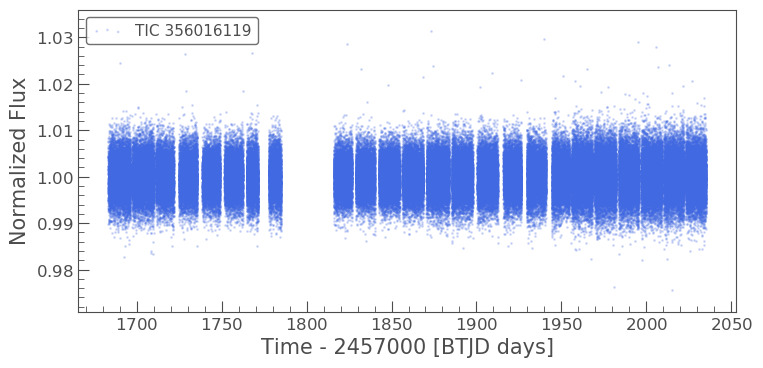

In [10]:
stitched_lc = lcf.PDCSAP_FLUX.stitch().remove_outliers(sigma=10)
stitched_lc.scatter(alpha=0.2,color='royalblue',rasterized=True)

In [11]:
planet_period = params['P (days)'][index] # must be in days
planet_radius = params['Rp/R*'][index] # Rp/R*
Epoch = params['Epoch'][index] 
planet_a = params['a/R*'][index] # a/R*
planet_b = params['b'][index] # impact parameter
planet_duration = params['Dur'][index] #hours
ppm_depth = params['Depth'][index] #ppm

planet_i = np.arccos(planet_b/planet_a)*180/np.pi #inclination in degrees
depth = (1-ppm_depth/1e6)

star_teff = params['T_eff'][index] # K
star_met = params['Met'][index] # metallicity
star_g = params['logg'][index] # log g
star_radius = params['R_s'][index] #R*/Rsun

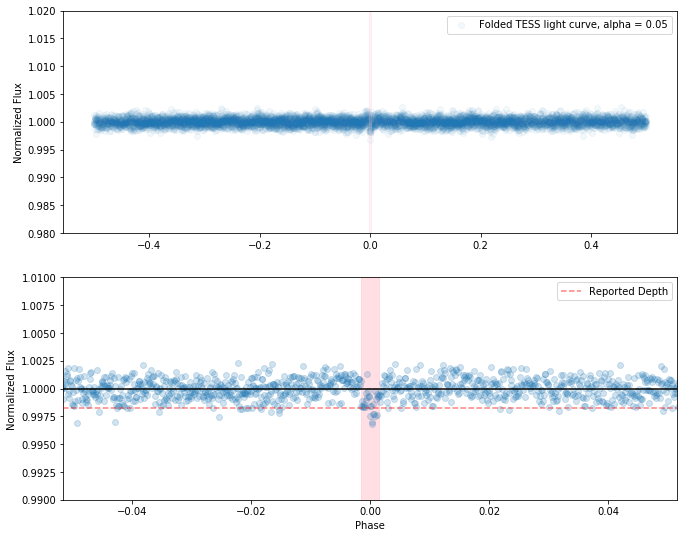

In [12]:
# This box will plot the full folded light curve as well as a zoomed in region on the transit

toi = 2094.01

T = planet_period
T0 = Epoch

folded_lc = stitched_lc.fold(period=T, t0=T0)

TLC = folded_lc

fig, (ax0,ax1) = plt.subplots(2,1,figsize=(11,9))

#init_model = BATMAN(planet_period,planet_radius,t0=Epoch,inc=planet_i,
#                    A=planet_a,LD=[0.31,0.32],t = TLC.time)


#ingress = (Epoch+n*planet_period)-(planet_duration/2)/24
ingress = (0-(planet_duration/2)/24)/T
#egress = (Epoch+n*planet_period)+(planet_duration/2)/24
egress = (0+(planet_duration/2)/24)/T

ax0.scatter(TLC.bin(binsize=30).time, TLC.bin(binsize=30).flux, alpha=0.05,rasterized=True, label = 'Folded TESS light curve, alpha = 0.05')
ax0.axvspan(ingress, egress, alpha=0.2, color='pink')

ax0.set_ylabel('Normalized Flux')
ax0.set_ylim(0.98,1.02)
ax0.legend()


ax1.scatter(TLC.bin(binsize=20).time, TLC.bin(binsize=20).flux, alpha=0.2,rasterized=True)
ax1.axvspan(ingress, egress, alpha=0.5, color='pink',zorder=-2)
ax1.axhline(1, color='k',zorder=100)
ax1.axhline(depth, color='r',zorder=100,label='Reported Depth',linestyle='--',alpha=0.5)
#ax1.plot(TLC.time, init_model, color='k',zorder=-1)

ax1.set_xlim(ingress-0.05, egress+0.05)
ax1.set_ylim(0.99,1.01)
ax1.set_ylabel('Normalized Flux')
ax1.set_xlabel('Phase')
ax1.legend()

plt.savefig(f'Figs/TOI_{toi}_TESS_folded.pdf')
plt.show()

In [7]:
# # n = np.ones(shape=100)

# period = np.array([1.4206040,2.8411470,10.4035780])
# epoch = np.array([1683.350647,1684.775586,1686.446763])
# durations = np.array([1.6,1.6,1.4])


# stitched_lc.scatter(alpha=0.2,color='royalblue',rasterized=True)
# plt.xlim(stitched_lc.time[0],stitched_lc.time[-1])
# plt.xlim(1683,1695)

# for i in range(len(n)):
#     transit = epoch + i*period
#     plt.axvline(transit[0],color='red',zorder=4000,alpha=0.4)
#     plt.axvline(transit[1],color='blue',zorder=5000,alpha=0.4)
#     plt.axvline(transit[2],color='black',zorder=1000,alpha=0.4)
    
# #plt.legend()
# plt.savefig('tess_transits.pdf')